# Investigate Weak formulation of ode solution for loss
Consider the stiff ode 

$$
\dot{x} = F(x;u), \quad x \in \Omega \subseteq \mathbb{R}^d
$$

Where we wish to learn $F$ via a paremterized $F_\theta$ via some (possibly noisy) observations $\{x_i\}_{i=1}^n$
Consider the test function $\{\phi_k\}_{k\in[K]} \in H^1$ (sobolev space) that is locally compact on an interval $T$ and a fixed $k$ we have

$$
\int_T \phi_k(t) \dot{x} dt = \int_T \phi_i(t)F(x;u)  dt
$$
$$
\underbrace{\phi_k(t)x \bigg|_{\partial T}}_{=0} - \int_T  \dot{\phi}_k(t)x(t)dt = \int_T \phi_k(t)F(x;u)  dt
$$

We can then define the following residual

$$
R_k(\theta) = \int_T \underbrace{\left(\dot{\phi}_k(t) x(t) + \phi_k(t) F_\theta(x;u)\right)}_{=I_k(t)}dt
$$
where can use a trapezodial rule to approximate the integral

$$
R_k \approx \hat{R}_k \triangleq \sum_{i=1}^{n-1} \frac{\Delta t_i}{2} \left[I_k(t_i) + I_k(t_{i+1})\right] = \mathcal{O}(\Delta t ^{p+1})
$$


<!-- $$
I_k(\theta)\triangleq \sum_{i=1}^n w_i \cdot \phi_k(t_i)\cdot F_\theta(x_i;u_i)\cdot\Delta t_i
$$
$$
D_k \triangleq -1 \cdot \sum_{i=1}^n w_i \cdot x_i \cdot \dot{\phi}_k(t_i)\cdot \Delta t_i
$$

to be quadrature approximations of the integrals above -->

We then define the least squares loss to be

$$
\mathcal{L}(\theta) \triangleq \sum_{k=1}^K \left| \hat{R}_k(\theta) \right|^2.
$$

Where the loss $\mathcal{L}$ can be minimzed in a classical optimizaiton approach. As well as NODE approach. Where we first try and let 

$$
F_\theta(x;u) := \texttt{StabNODE(Felu, Gelu)}
$$

where $\theta$ are the tunable parameters in $\texttt{Felu}$ and $\texttt{Gelu}$


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from stabnode.utils import set_global_seed

seed = 1234
set_global_seed(seed=seed)

### Test functions ($\phi$) from [Weak SINDY: Galerkin-based Data-Driven Model Selection](https://arxiv.org/abs/2005.04339) 

Let $\mathcal{S}$ be the space of unimodal piecewise polynomials

$$
\phi(t) = \begin{cases}
    C(t-a)^p(b-t)^q, & t \in [a,b]\\
    0, & \text{otherwise},
\end{cases}
$$
with $(a,b) \subset t\times t$, $a<b$, and $p,q \geq 1$. And the normalization constant give by 
$$
C = \frac{1}{p^p q^q}\left(\frac{p+q}{b-a}\right)^{p+q}
$$

We also include the first derivative



$$
\partial_t \phi(t) = \begin{cases}
C \bigg(p(t-a)^{p-1}(b-t)^q - (t-a)^pq(b-t)^{q-1}\bigg), & t\in [a,b]\\
0, & \text{otherwise},
\end{cases}
$$

In [3]:
a,b,p,q = 1,4,1,1
def phi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    vals[mask] = C*(t[mask]-a)**p*(b-t[mask])**q
    return vals

def dphi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    term1 = p*(t[mask]-a)**(p-1)*(b-t[mask])**q
    term2 = (t[mask]-a)**p*q*(b-t[mask])**(q-1)
    vals[mask] = C*(term1-term2)
    return vals


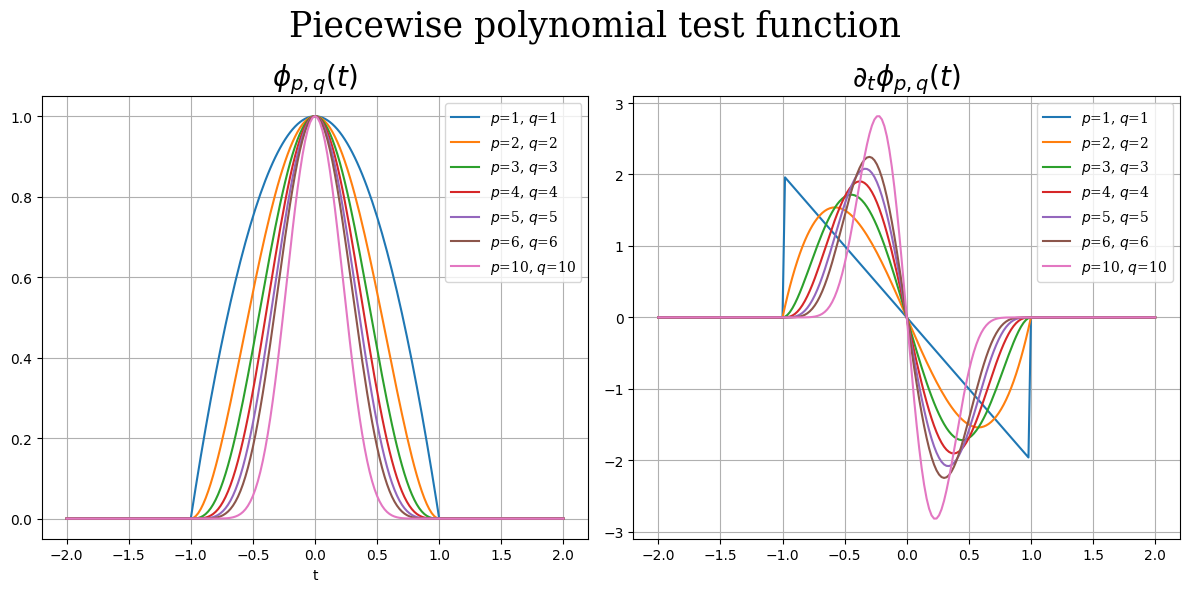

In [4]:
fig, (ax1,ax2)  = plt.subplots(1,2,figsize=(12,6))

t_vals = torch.linspace(-2,2,201)
a,b=-1,1
ps = [1,2,3,4,5,6,10]
qs = [1,2,3,4,5,6,10]
for p,q in zip(ps,qs):
    label = rf"$p$={p}, $q$={q}"
    ax1.plot(t_vals,phi(t_vals,a,b,p,q),label=label)
    ax2.plot(t_vals,dphi(t_vals,a,b,p,q),label=label)
ax1.grid(True)
ax1.set_title(r"$\phi_{p,q}(t)$",size=20,family='serif')
ax1.set_xlabel(r"t")
ax1.legend(prop={'family':'serif'})
ax2.grid(True)
ax2.set_title(r"$\partial_t\phi_{p,q}(t)$",size=20,family='serif')
ax2.legend(prop={'family':'serif'})
plt.suptitle("Piecewise polynomial test function",family='serif',size=25)
plt.tight_layout()
plt.savefig("piecewise_poly_test_functions.png")
plt.show()

In [5]:
from stabnode.node import StabNODE, Felu, Gelu
from data.hysteresis import simulate_steady_state

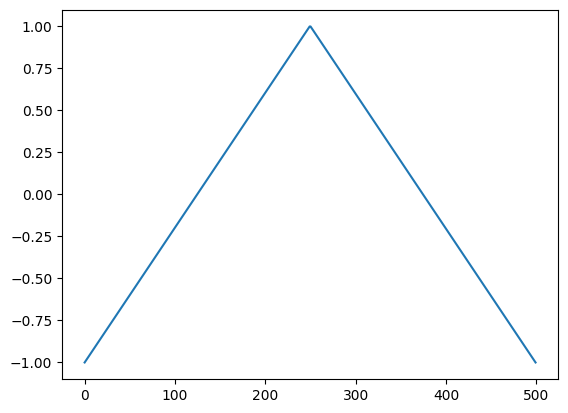

In [6]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam_np = np.hstack((lam_increase,lam_decrease))
repeat = 0
for _ in range(repeat):
    lam_np = np.hstack((lam_np, lam_np))
plt.plot(lam_np)
plt.show()


In [7]:
X, lam, t=simulate_steady_state(lam_np,x0=-1.31,t_span=[0,20],t_eval=np.linspace(0,20,201))

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
interp_lam = interp1d(t.numpy(), lam.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor) -> torch.Tensor:
    """
    t: Tensor of shape [B] or scalar
    Returns: Tensor of shape [B, 1]
    """
    if t.dim() == 0:  # scalar time
        t_scalar = t.item()
        lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
        return lam_t.unsqueeze(0)
    else:  # batched time
        lam_t = interp_lam(t.detach().cpu().numpy())  # shape [B,]
        lam_t = torch.tensor(lam_t, dtype=torch.float32).unsqueeze(1)  # shape [B, 1]
        return lam_t.to(t.device)

In [9]:
sample_rate =100
train_idx = torch.arange(0,len(t),sample_rate)
X_train = X[:,train_idx]
t_train = t[train_idx]
lam_train = lam[train_idx]

In [10]:
f = Felu(1,1,4)
g = Gelu(2,1,2)

model = StabNODE(f,g).to('cpu')

In [11]:
i=1
model.f(X_train[:,i])

tensor([-1.1973], grad_fn=<NegBackward0>)

In [12]:
t_train[i], X_train[:,i], control_func(t_train[i])

(tensor(10.), tensor([-1.3249]), tensor([-1.]))

In [13]:
X[:,:10].T.shape, control_func(t_train[:10]).shape

(torch.Size([10, 1]), torch.Size([10, 1]))

In [14]:
test = torch.cat([X[:,:10].T,control_func(t_train[:10])],dim=-1)

In [15]:
test

tensor([[-1.3100, -1.0000],
        [-1.3151, -1.0000],
        [-1.3186, -1.0000],
        [-1.3212, -0.9920],
        [-1.3227, -0.9920],
        [-1.3231, -0.9839],
        [-1.3231, -0.9839],
        [-1.3235, -0.9759],
        [-1.3240, -0.9759],
        [-1.3243, -0.9679]])

In [16]:
model.g.network(test)

tensor([[-0.3303],
        [-0.3310],
        [-0.3315],
        [-0.3328],
        [-0.3330],
        [-0.3340],
        [-0.3340],
        [-0.3349],
        [-0.3350],
        [-0.3359]], grad_fn=<TanhBackward0>)

In [17]:
i=1
model(t_train[i:i+1],X_train[:,i],control_func)

tensor([[1.1883]], grad_fn=<MulBackward0>)

In [18]:
control_func(t[:10]).shape


torch.Size([10, 1])

In [19]:
# we have access to a t and a x array and u array (or u func)? 
from stabnode.utils import _load_loop_wrapper

t
X
lam
phi_order = 5
decay_rate = 1000

dt = t[1:] - t[:-1]
dt = torch.cat((dt[0:1],dt,dt[-2:-1]))

def phi_k(i,k):
    ti = t[i]
    tk = t[k]
    return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

def dphi_k(i,k):
    ti=t[i]
    tk = t[k]
    return dphi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

def integrand(i,k):
    xi = X[:,i].T
    ti = t[i]
    return dphi_k(i,k)*xi.squeeze()+phi_k(i,k)*model(ti,xi, control_func).squeeze()
loop_wrapper = _load_loop_wrapper(True)

def trapezoid(k):
    n = len(t)
    integral = 0
    for i in loop_wrapper(range(0,n-1)):
        integral += (dt[i] / 2 ) * (integrand(i,k)+integrand(i+1,k))
    return integral

def trapezoid_vec(k):
    indices = torch.arange(len(t))
    I = integrand(indices,k)
    trap = (dt[1:-1] / 2 ) * (I[:-1]+I[1:])
    return trap

def weak_MSELoss(t,X,model,control_func, phi_order, decay_rate,show_progress=True):
    dt = t[1:] - t[:-1]
    dt = torch.cat((dt[0:1],dt,dt[-2:-1]))

    def phi_k(i,k):
        ti = t[i]
        tk = t[k]
        return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def dphi_k(i,k):
        ti=t[i]
        tk = t[k]
        return dphi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def integrand(i,k):
        xi = X[:,i].T
        ti = t[i]
        return dphi_k(i,k)*xi.squeeze()+phi_k(i,k)*model(ti,xi, control_func).squeeze()

    def trapezoid(k):
        indices = torch.arange(len(t))
        I = integrand(indices,k)
        trap = (dt[1:-1] / 2 ) * (I[:-1]+I[1:])
        return trap    

    K = len(t)
    weak_loss = 0.0
    loop_wrapper = _load_loop_wrapper(show_progress)
    for k in loop_wrapper(range(K)):
        weak_loss += torch.sum(trapezoid(k)**2)
    
    return weak_loss / K


In [20]:
indices = torch.arange(len(t))

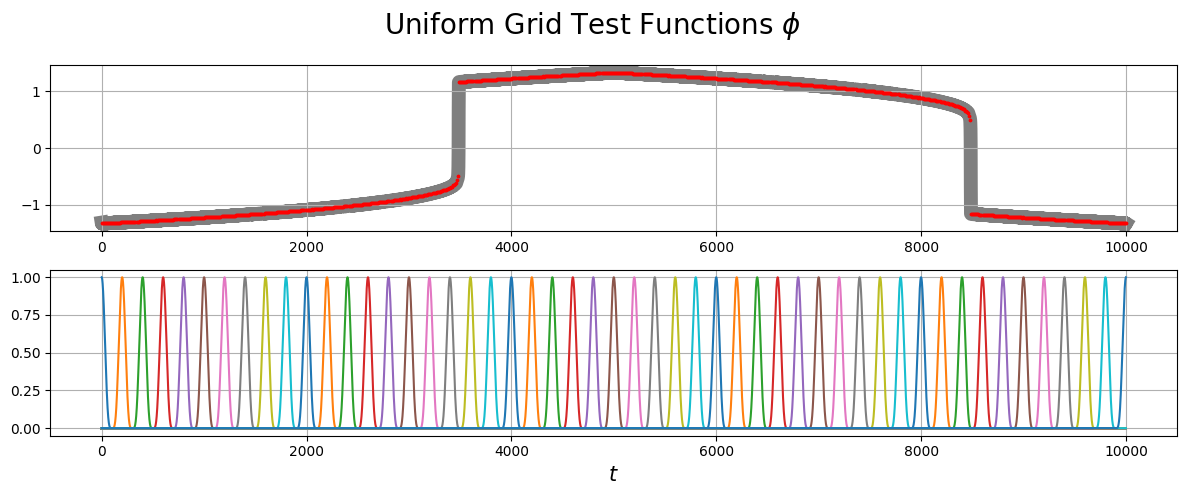

In [21]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,5))
k_vals = torch.arange(0,len(t),5000)


ax1.plot(t,X[0,:],c='black',alpha=0.5,lw=10,zorder=1)
ax1.scatter(t_train, X_train,zorder=2,c='red',s=3)
ax1.grid(True)
k_vals=train_idx
for k in k_vals[::20]:
    ax2.plot(t,phi_k(indices,k))

ax2.set_xlabel(r"$t$",size=15)
ax2.grid(True)
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle(r"Uniform Grid Test Functions $\phi$", size=20)
plt.show()

In [24]:
loss = weak_MSELoss(t_train, X_train, model, control_func, phi_order = 5, decay_rate=1000)

  0%|          | 0/1001 [00:00<?, ?it/s]

### vectorized `integrand()`

In [36]:
idx = torch.arange(len(t_train))
ti = t[idx]
xi = X[:,idx].T
ti.shape, xi.shape

(torch.Size([1001]), torch.Size([1001, 1]))

In [39]:
model_out = model(ti, xi, control_func)
model_out.shape

torch.Size([1001, 1])

In [42]:
k = 10

phi_k_out = phi_k(idx,k)
dphi_k_out = dphi_k(idx,k)

phi_k_out.shape, dphi_k_out.shape

(torch.Size([1001]), torch.Size([1001]))

In [43]:
dphi_k_out.shape, xi.shape, phi_k_out.shape, model_out.shape

(torch.Size([1001]),
 torch.Size([1001, 1]),
 torch.Size([1001]),
 torch.Size([1001, 1]))

In [52]:
dphi_k_out*xi.squeeze() + phi_k_out*model_out.squeeze()

tensor([1.1668e+00, 1.1737e+00, 1.1785e+00,  ..., 5.1243e-08, 3.5761e-08,
        2.4127e-08], grad_fn=<AddBackward0>)

In [58]:
I_out = integrand(idx,k=10)

In [66]:
(I_out[:-1]+I_out[1:])*dt_train /2 

tensor([1.1702e+01, 1.1761e+01, 1.1804e+01, 1.1833e+01, 1.1848e+01, 1.1852e+01,
        1.1856e+01, 1.1864e+01, 1.1871e+01, 1.1875e+01, 1.1877e+01, 1.1879e+01,
        1.1881e+01, 1.1884e+01, 1.1886e+01, 1.1887e+01, 1.1887e+01, 1.1886e+01,
        1.1885e+01, 1.1886e+01, 1.1890e+01, 1.1894e+01, 1.1897e+01, 1.1897e+01,
        1.1894e+01, 1.1888e+01, 1.1881e+01, 1.1875e+01, 1.1872e+01, 1.1875e+01,
        1.1880e+01, 1.1883e+01, 1.1883e+01, 1.1879e+01, 1.1873e+01, 1.1869e+01,
        1.1868e+01, 1.1870e+01, 1.1871e+01, 1.1870e+01, 1.1866e+01, 1.1861e+01,
        1.1857e+01, 1.1855e+01, 1.1855e+01, 1.1856e+01, 1.1856e+01, 1.1852e+01,
        1.1846e+01, 1.1837e+01, 1.1830e+01, 1.1825e+01, 1.1825e+01, 1.1827e+01,
        1.1827e+01, 1.1824e+01, 1.1817e+01, 1.1807e+01, 1.1797e+01, 1.1792e+01,
        1.1792e+01, 1.1793e+01, 1.1793e+01, 1.1788e+01, 1.1779e+01, 1.1767e+01,
        1.1756e+01, 1.1750e+01, 1.1751e+01, 1.1753e+01, 1.1752e+01, 1.1746e+01,
        1.1734e+01, 1.1720e+01, 1.1708e+

In [74]:
torch.sum(trapezoid_vec(10)**2)

tensor(4.1040, grad_fn=<SumBackward0>)

In [65]:
dt_train = t_train[1:] - t_train[:-1]
dt_train.shape

torch.Size([1000])

In [53]:
_.shape

torch.Size([1001])

In [48]:
trapezoid(10)

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([[88.6357]], grad_fn=<AddBackward0>)

In [108]:
idx = torch.arange(len(t))

In [101]:
t[idx].shape, X[:,idx].shape

(torch.Size([100001]), torch.Size([1, 100001]))

In [103]:
ti = t[idx]
xi = X[:,idx]
ti.shape, xi.shape

(torch.Size([100001]), torch.Size([1, 100001]))

In [106]:
model(ti,xi.T,control_func).shape

torch.Size([100001, 1])

In [109]:
k=10
integrand(idx,k)

: 